# Machine learning with graphs

## Homework 2 (Assignment 2)

Solution notebook for Homeworks proposed in the [MLG](http://jcid.webs.tsc.uc3m.es/machine-learning-group/) in the seminar of 2021 based on [Machine learning with graphs](http://snap.stanford.edu/class/cs224w-2019/) course by Standford university.

    Author: Daniel Bacaicoa Barber (27 feb, 2021)
    
<font size="1">This notebook may contain several errata. Note that the solution is the one I proposed and may not be the best or more efficient. Use it at your own risk.</font>

In [1]:
#Importing generic libraries.
import numpy as np
import pandas as pd
import scipy 

# Graph related libraries 
import networkx as nx

# Util libraries
from collections import Counter, OrderedDict
import itertools
import random

#Plotting library
import matplotlib.pyplot as plt

### 1 Network Characteristics
One of the goals of network analysis is to find mathematical models that characterize real-world
networks and that can then be used to generate new networks with similar properties. In this
problem, we will explore two famous models --Erdös-Rényi and Small World-- and compare them
to real-world data from an academic collaboration network. Note that in this problem all networks
are undirected. You may use the starter code in hw1-q1-starter.py for this problem.

> Erdös-Rényi Random graph ($G(n,m)\ random\ network$): Generate a random instance of this
model by using n = 5242 nodes and picking m = 14484 edges at random. Write code to
construct instances of this model, i.e., do not call a SNAP function.


**Note**:

The total number of edges in an *undirected* graph (with *self edges*) is computed as:

$$E=\frac{1}{2}\sum_{i=1}^N\sum_{\substack{j=1\\j\neq i}}^N A_{ij} \left(+ \sum_{i=1}^N A_{ii}\right)$$

which means that we have to select E values equal to 1 in the strictly upper triangular matrix (upper triangular matrix). Same with the lower matrix.


In [2]:
def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: nx.Graph (undirected_graph) 
    return: Erdos-Renyi graph with N nodes and E edges
    """
    possible_edges = list(itertools.combinations(range(N), 2))
    possible_edges = random.sample(possible_edges,k=E)
    
    Graph = nx.Graph()
    Graph.add_nodes_from(range(N))
    Graph.add_edges_from(possible_edges)

    return Graph

Number of nodes in the toy Erdos-Renyi random graph is: 20
Number of edges in the toy Erdos-Renyi random graph is: 10


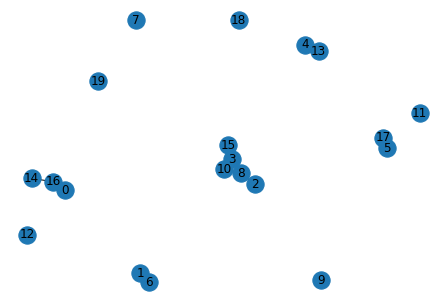

In [3]:
#We plot an easy example
Toy_erdos = genErdosRenyi(N=20,E=10)
print('Number of nodes in the toy Erdos-Renyi random graph is: %i'%Toy_erdos.number_of_nodes())
print('Number of edges in the toy Erdos-Renyi random graph is: %i'%Toy_erdos.number_of_edges())
nx.draw(Toy_erdos,with_labels=True)


We have that the graph has a largest connected component for $\overline{k} >1$, i.e., $p (n-1) > 1$.

$$p = \frac{E}{E_{max}} = \frac{E}{\frac{n(n-1)}{2}} =  \frac{2E}{n(n-1)} = \frac{2E}{n(n-1)} $$

so, the graph has a largest connected component if $\frac{2E}{n} > 1 \ \Rightarrow E > \frac{n}{2} $



> Small-World Random Network: Generate an instance from this model as follows: begin with
n = 5242 nodes arranged as a ring, i.e., imagine the nodes form a circle and each node is
connected to its two direct neighbors (e.g., node 399 is connected to nodes 398 and 400),
giving us 5242 edges. Next, connect each node to the neighbors of its neighbors (e.g., node
399 is also connected to nodes 397 and 401). This gives us another 5242 edges. Finally,
randomly select 4000 pairs of nodes not yet connected and add an edge between them. In
total, this will make m = 5242 $\cdot$ 2 + 4000 = 14484 edges. Write code to construct instances of
this model, i.e., do not call a SNAP function.



In [4]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: nx.Graph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    
    edges = list(zip(list(range(N)),[(i+1) % N for i in range(N)]))
    Graph = nx.Graph()
    Graph.add_nodes_from(range(N))
    Graph.add_edges_from(edges)
    
    return Graph

Number of nodes in the toy circle graph is: 20
Number of edges in the toy circle graph is: 20


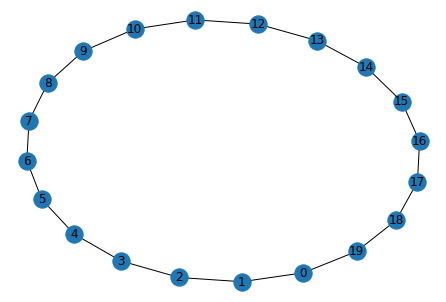

In [5]:
#We plot an easy example
Toy_circle = genCircle(N=20)
print('Number of nodes in the toy circle graph is: %i'%Toy_circle.number_of_nodes())
print('Number of edges in the toy circle graph is: %i'%Toy_circle.number_of_edges())
nx.draw(Toy_circle,with_labels=True)

In [6]:
def connectNbrOfNbr(Graph, N=5242):
    """
    :param - Graph: nx.Graph object representing a circle graph on N nodes
    :param - N: number of nodes

    return type: nx.Graph
    return: Graph object with additional N edges added by connecting each node
        to the neighbors of its neighbors
    """
    edges = list(zip(list(range(N)),[(i+2) % N for i in range(N)]))
    Graph.add_edges_from(edges)
    
    return Graph

Number of nodes in the toy neighbour circle graph is: 20
Number of edges in the toy neighbour circle graph is: 40


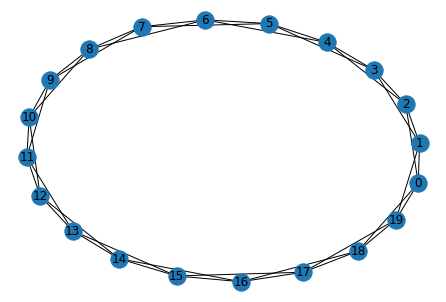

In [7]:
#We plot an easy example
Toy_NeigCirc = connectNbrOfNbr(Toy_circle,N = Toy_circle.number_of_nodes())

print('Number of nodes in the toy neighbour circle graph is: %i'%Toy_NeigCirc.number_of_nodes())
print('Number of edges in the toy neighbour circle graph is: %i'%Toy_NeigCirc.number_of_edges())
nx.draw(Toy_NeigCirc,with_labels=True)

In [8]:
def connectRandomNodes(Graph, M=4000):
    """
    :param - Graph: nx.Graph object representing an undirected graph
    :param - M: number of edges to be added

    return type: nx.Graph
    return: Graph object with additional M edges added by connecting M randomly
        selected pairs of nodes not already connected.
    """
    N = Graph.number_of_nodes()
    all_edges = list(itertools.combinations(range(N), 2))
    random.shuffle(all_edges)
    #possible_edges = [item for item in all_edges if item not in list(Graph.edges())] #very slow
    if M > (N*(N-1)/2 - 2*N) :
        raise Exception("The number of extra edges, E, should be less than %i"%(N*(N-1)/2))
    edges = []
    for edge in all_edges:
        if 2 < np.abs(edge[0]-edge[1]) < N-1:
            edges.append(edge)
            if len(edges)==M:
                break
    
    Graph.add_edges_from(edges)
    
    return Graph

Number of nodes in the toy neighbour circle random graph is: 20
Number of edges in the toy neighbour circle random graph is: 50


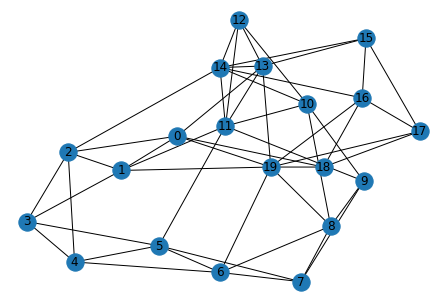

In [9]:
Toy_RandCirc = connectRandomNodes(Toy_NeigCirc, M = 10)
print('Number of nodes in the toy neighbour circle random graph is: %i'%Toy_RandCirc.number_of_nodes())
print('Number of edges in the toy neighbour circle random graph is: %i'%Toy_RandCirc.number_of_edges())
nx.draw(Toy_RandCirc,with_labels=True)

In [10]:
def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: nx.Graph
    return: Small-World graph with N nodes and E edges
    """
    if E < 2*N or E > N*(N-1)/2:
        raise Exception("The number of edges, E, should be between [%i,%i]"%(2*N,N*(N-1)/2)) #N/2 bbecause we are not appecting self loops
    Graph = genCircle(N)
    Graph = connectNbrOfNbr(Graph, N)
    Graph = connectRandomNodes(Graph, M = E - 2*N )
    return Graph

Number of nodes in the toy Small-World random graph is: 20
Number of edges in the toy Small-World random graph is: 41
All degrees shoud be 4 except for 2 nodes that should be 5
Degrees are:  [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4]


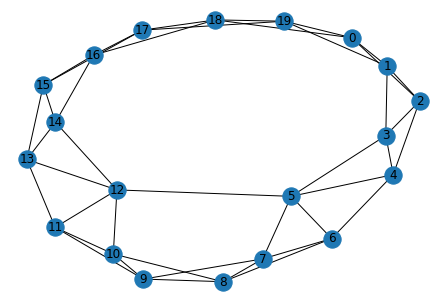

In [11]:
Toy_SmallWorld = genSmallWorld(N = 20, E = 41)
print('Number of nodes in the toy Small-World random graph is: %i'%Toy_SmallWorld.number_of_nodes())
print('Number of edges in the toy Small-World random graph is: %i'%Toy_SmallWorld.number_of_edges())
nx.draw(Toy_SmallWorld,with_labels=True)
print('All degrees shoud be 4 except for 2 nodes that should be 5')
print('Degrees are: ', list(dict(Toy_SmallWorld.degree()).values()))

> Real-World Collaboration Network: Download [this undirected network](http://snap.stanford.edu/data/ca-GrQc.txt.gz). Nodes in this network represent authors of research
papers on the arXiv in the General Relativity and Quantum Cosmology section. There is
an edge between two authors if they have co-authored at least one paper together. Note
that some edges may appear twice in the data, once for each direction. Ignoring repeats and
self-edges, there are 5242 nodes and 14484 edges. (Note: Repeats are automatically ignored
when loading an (un)directed graph with SNAP's LoadEdgeList function).

In [12]:
def loadCollabNet(path):
    """
    :param - path: path to edge list file

    return type: nx.Graph
    return: Graph loaded from edge list at `path and self edges removed

    Do not forget to remove the self edges!
    """
    Graph = nx.read_edgelist(path,create_using = nx.Graph(), nodetype = int)
    Graph.remove_edges_from(nx.selfloop_edges(Graph))
    
    return Graph

#### 1.1 Degree Distribution
Generate a random graph from both the Erdös-Rényi (i.e., $G(n,m)$) and Small-World models and
read in the collaboration network. Delete all of the self-edges in the collaboration network (there
should be 14,484 total edges remaining).

Plot the degree distribution of all three networks in the same plot on a log-log scale. In other words,
generate a plot with the horizontal axis representing node degrees and the vertical axis representing
the proportion of nodes with a given degree (by "log-log scale" we mean that both the horizontal
and vertical axis must be in logarithmic scale). In one to two sentences, describe one key difference
between the degree distribution of the collaboration network and the degree distributions of the
random graph models.

In [13]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: nx.Graph object representing an undirected graph

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    degrees = list(dict(Graph.degree()).values())
    count = dict(Counter(degrees))
    ordered_count = dict(OrderedDict(sorted(count.items())))
    x = list(ordered_count.keys())
    y = np.array(list(ordered_count.values()))
    X, Y = x, list(y/np.sum(y))

    return X, Y

In [14]:
def Q1_1():
    """
    Code for HW1 Q1.1
    """
    global erdosRenyi, smallWorld, collabNet
    erdosRenyi = genErdosRenyi(5242, 14484)
    smallWorld = genSmallWorld(5242, 14484)
    collabNet = loadCollabNet("ca-GrQc.txt")

    x_erdosRenyi, y_erdosRenyi = getDataPointsToPlot(erdosRenyi)
    plt.loglog(x_erdosRenyi, y_erdosRenyi, color = 'y', label = 'Erdos Renyi Network')

    x_smallWorld, y_smallWorld = getDataPointsToPlot(smallWorld)
    plt.loglog(x_smallWorld, y_smallWorld, linestyle = 'dashed', color = 'r', label = 'Small World Network')

    x_collabNet, y_collabNet = getDataPointsToPlot(collabNet)
    plt.loglog(x_collabNet, y_collabNet, linestyle = 'dotted', color = 'b', label = 'Collaboration Network')

    plt.xlabel('Node Degree (log)')
    plt.ylabel('Proportion of Nodes with a Given Degree (log)')
    plt.title('Degree Distribution of Erdos Renyi, Small World, and Collaboration Networks')
    plt.legend()
    plt.show()

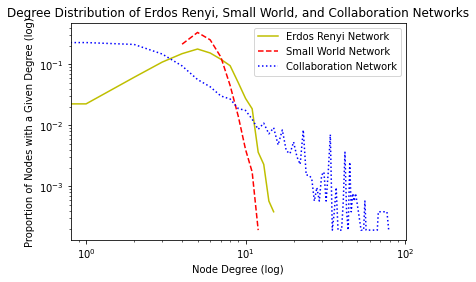

In [15]:
# Execute code for Q1.1
Q1_1()

In [16]:
print('Number of nodes in the ErdosRenyi random graph is: %i'%erdosRenyi.number_of_nodes())
print('Number of edges in the ErdosRenyi random graph is: %i'%erdosRenyi.number_of_edges())
print('\nNumber of nodes in the Small-World random graph is: %i'%smallWorld.number_of_nodes())
print('Number of edges in the Small-World random graph is: %i'%smallWorld.number_of_edges())
print('\nNumber of nodes in the Author graph is: %i'%collabNet.number_of_nodes())
print('Number of edges in the Author graph is: %i'%collabNet.number_of_edges())

Number of nodes in the ErdosRenyi random graph is: 5242
Number of edges in the ErdosRenyi random graph is: 14484

Number of nodes in the Small-World random graph is: 5242
Number of edges in the Small-World random graph is: 14484

Number of nodes in the Author graph is: 5242
Number of edges in the Author graph is: 14484


#### 1.2 Clustering Coefficient
Recall that the local clustering coefficient for a node vi was defined in class as

$$ C_i = \begin{cases}\frac{2|e_i|}{k_i\cdot(k_i-1)} & k_i \geq 2 \\
0 & \mathrm{otherwise}\end{cases}$$

where $k_i$ is the degree of node $v_i$ and $e_i$ is the number of edges between the neighbors of $v_i$. The
*average clustering coefficient* is defined as

$$C=\frac{1}{|V|}\sum_{i\in V}C_i$$

Compute and report the average clustering coefficient of the three networks. For this question,
write your own implementation to compute the clustering coefficient, instead of using a built-in
SNAP function.

Which network has the largest clustering coefficient? In one to two sentences, explain. Think about
the underlying process that generated the network.

#### Note:
We give a fist solution based on the adjacency matrix.

As we have an undirected graph, we use the fact that the neigborhodd of a node is given by the nonnegative elements in the row (column) of a cetain node. 

$$A = \begin{pmatrix}
0 & 1 & 1 & 0 & 1\\
1 & 0 & 1 & 0 & 1\\
1 & 1 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 1\\
1 & 1 & 0 & 1 & 0\\
\end{pmatrix}$$ 

so the neighborhood of node 0 is given by $[1,2,4]$. Thus, the adjacency of the neighborhood is given by,

$$A^{Neig} = A([1,2,4],[1,2,4]) = \begin{pmatrix}
 1 & 1  & 1\\
 1 & 0  & 0\\
 1 & 0  & 0\\
\end{pmatrix}$$ 

$e_0 = \frac{1}{2}\sum_{i,j}A^{Neig}_{i,j}$. And the possible edges are given as a function of $n^{Neig}_0 = 3$ by $E^{Neig}_{max} =\frac{n^{Neig}_0(n^{Neig}_0-1)}{2}$ so,

$$C_0 = \frac{e_0}{E^{Neig}_{max}} = \frac{2 e_0}{n_{neig}(n_{neig}-1)}$$

In [17]:
def Clustering_coef(Graph):
    A = nx.adjacency_matrix(Graph)
    A = A.todense()
    Ci = []
    
    for i,node in enumerate(range(A.shape[0])):
        Neig = np.where(A[i,:]==1)[1]
        if len(Neig)<2:
            Ci.append(0)
        else:
            Ci.append(np.sum(A[Neig[:,None], Neig[None,:]]==1)/(np.sum(A[Neig[:,None], Neig[None,:]]<2)-len(Neig)))
    
    return np.mean(np.array(Ci)), np.array(Ci)

In [18]:
#Verifying for the graphs in the previous section:
c_er,_ = Clustering_coef(erdosRenyi)
print('Average clustering coefficient for the Edos-Renyi graph model is %0.4f'%c_er)

c_sw,_ = Clustering_coef(smallWorld)
print('Average clustering coefficient for the Small-World graph model is %0.4f'%c_sw)

c_aut,_ = Clustering_coef(collabNet)
print('Average clustering coefficient for the arXiv author graph model is %0.4f'%c_aut)

Average clustering coefficient for the Edos-Renyi graph model is 0.0009
Average clustering coefficient for the Small-World graph model is 0.2843
Average clustering coefficient for the arXiv author graph model is 0.5296


In [19]:
def Q1_2():
    """
    Code for Q1.2
    """
    C_erdosRenyi = Clustering_coef(erdosRenyi)
    C_smallWorld = Clustering_coef(smallWorld)
    C_collabNet = Clustering_coef(collabNet)

    print('Clustering Coefficient for Erdos Renyi Network: %f' % C_erdosRenyi[0])
    print('Clustering Coefficient for Small World Network: %f' % C_smallWorld[0])
    print('Clustering Coefficient for Collaboration Network: %f' % C_collabNet[0])

In [20]:
# Execute code for Q1.2
Q1_2()

Clustering Coefficient for Erdos Renyi Network: 0.000913
Clustering Coefficient for Small World Network: 0.284268
Clustering Coefficient for Collaboration Network: 0.529636
